In [1]:
%pip install spacy_thai
%pip install gensim

^C
Note: you may need to restart the kernel to use updated packages.


: 

: 

^C



KeyboardInterrupt



In [2]:
%pip install pythainlp
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
import numpy as np 
import pandas as pd
import sys
sys.executable

'c:\\Users\\User\\OneDrive\\Desktop\\seen_jupyter\\venv\\Scripts\\python.exe'

In [3]:
# df = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\seen_jupyter\research\prachatai(TK Edition).csv')
df_train = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\seen_jupyter\research\archive\prachatai_train.csv')
df_valid = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\seen_jupyter\research\archive\prachatai_validation.csv')
df_test = pd.read_csv(r'C:\Users\User\OneDrive\Desktop\seen_jupyter\research\archive\prachatai_test.csv')
df_train.shape
df_valid.shape
df_test.shape

(6789, 17)

In [25]:
from pythainlp.corpus.common import thai_stopwords

stop = set(thai_stopwords())
n_head = 4000
label_cols = ["politics","human_rights","quality_of_life","international","social","environment","economics","culture","labor","national_security","ict","education"]
  
def split_IO(dataframe):
    # X =  dataframe["body_text"].head(n_head).fillna("").astype(str).tolist() #["...", "...", "..."] ลด NaN
    X =  dataframe["body_text"].fillna("").astype(str).tolist() #["...", "...", "..."] ลด NaN

    # Y = dataframe[label_cols].head(n_head).fillna(0).astype(np.float32).to_numpy()
    Y = dataframe[label_cols].fillna(0).astype(np.float32).to_numpy()
    print("X shape:",len(X),",Y shape:", Y.shape)
    assert len(X) == Y.shape[0]
    return X, Y

X_train, Y_train = split_IO(df_train)
X_valid, Y_valid = split_IO(df_valid)
X_test, Y_test = split_IO(df_test)

X shape: 54379 ,Y shape: (54379, 12)
X shape: 6721 ,Y shape: (6721, 12)
X shape: 6789 ,Y shape: (6789, 12)


In [17]:
import re
from pythainlp.util import normalize
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords

stop = set(thai_stopwords())

# --- กรอง token ให้อยู่ในรูปที่ model ใช้ง่าย ---
_token_ok = re.compile(r"^[ก-๙a-zA-Z0-9]+$")

def clean_text(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.replace("\xa0", " ").replace("\t", " ").replace("\r", " ").replace("\n", " ")
    s = normalize(s)
    s = s.replace('"', " ").replace('”', " ").replace("''", " ")   
    # ยุบช่องว่างหลายๆอันให้เหลือช่องว่างเดียว
    s = re.sub(r"\s+", " ", s).strip()
    return s
     

def preprocessing(list_text, engine="newmm", min_len=2, keep_num=True):
    tovec_list = []
    tfidf_list = []
    for text in list_text:
        text = clean_text(text)
        tokenized_data = word_tokenize(text, engine=engine)
        cleaned_text = []
        for tokenized_word in tokenized_data:
            tokenized_word = tokenized_word.strip()

            if not tokenized_word:
                continue
            if len(tokenized_word) < min_len:
                continue
            if tokenized_word in stop:
                continue
            if not _token_ok.match(tokenized_word):
                continue
            if not keep_num and tokenized_word.isdigit():
                continue
            cleaned_text.append(tokenized_word)

        tovec_list.append(cleaned_text)
        tfidf_list.append(" ".join(cleaned_text))
    return tovec_list, tfidf_list



In [18]:
# TF-IDF
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(
#     ngram_range=(1,2),   # unigram, bigram 
#     min_df=2 # at least appear in 2 documents
# )

# tovec_list, tfidf_list = preprocessing(list_txt)
# # print(tfidf_list)
# outcome = vectorizer.fit_transform(tfidf_list)
# print(outcome.shape)
# sample = outcome[:100]
# outcome_df = pd.DataFrame(sample.toarray(), columns=vectorizer.get_feature_names_out())
# outcome_df


In [7]:
# Thai2Vec
from pythainlp.word_vector import WordVector

class Thai2VecEncoder:
    def __init__(self):
        # โหลด pretrained model แค่ครั้งเดียว
        self.wv = WordVector(model_name="thai2fit_wv").get_model()
        self.dim = self.wv.vector_size

    def doc_vector(self, tokens: list):
        """
        tokens: list[str] ของข่าว 1 ชิ้น
        return: vector (dim,)
        """
        vecs = []

        for tok in tokens:
            if tok in self.wv:
                vecs.append(self.wv[tok])

        if not vecs:
            return np.zeros(self.dim, dtype=np.float32)

        return np.mean(vecs, axis=0).astype(np.float32) # เฉลี่ยตามเเกนในเเนวตั้ง 

    def transform(self, tovec_list: list):
        """
        tovec_list: list[list[str]]
        return: X shape (n_docs, dim)
        """
        return np.vstack([self.doc_vector(tokens) for tokens in tovec_list])
    
    def oov_rate(self, tovec_list, wv_model):
        total = 0
        oov = 0
        for toks in tovec_list:
            for t in toks:
                total += 1
                if t not in wv_model:
                    oov += 1
        return (oov / total) if total else 0.0


# tovec_list, _ = preprocessing(X)

# encoder = Thai2VecEncoder()

# X = encoder.transform(tovec_list)

# print(X)
# print(np.isnan(X).any(), np.isinf(X).any())
# print("row norms:", np.linalg.norm(X, axis=1))
# print("OOV rate:", encoder.oov_rate(tovec_list, encoder.wv))
# (จำนวนข่าว, 300

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# MLP for Multi-label Classification
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, f1_score


# -------------------------
# Dataset
# -------------------------
class NumpyDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# -------------------------
# Model
# -------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, n_labels: int, hidden_dim: int = 256, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, n_labels)
        )

    def forward(self, x):
        return self.net(x)


# -------------------------
# Pipeline (OOP)
# -------------------------
class Thai2VecMLPPipeline:
    def __init__( self, preprocessing, encoder, label_names, batch_size=64, epochs=20, lr=1e-3, seed=42, threshold=0.5, hidden_dim=256, dropout=0.2, device=None):
        self.preprocessing = preprocessing
        self.encoder = encoder
        self.label_names = list(label_names)
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.seed = seed
        self.threshold = threshold
        self.hidden_dim = hidden_dim
        self.dropout = dropout

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        self.model = None
        self.criterion = None

    def _set_seed(self):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

    def _check_xy(self, X_texts, Y):
        assert isinstance(X_texts, (list, tuple)), "X_texts ต้องเป็น list[str]"
        assert Y.ndim == 2, "Y ต้องเป็น 2D (n_docs, n_labels)"
        assert len(X_texts) == Y.shape[0], "len(X_texts) ต้องเท่ากับ row Y"
        assert Y.shape[1] == len(self.label_names),  "จำนวน label_names ต้องเท่ากับ col Y"

    def _vectorize(self, texts):
        tovec_list, _ = self.preprocessing(texts)
        X_vec = self.encoder.transform(tovec_list)  # (n, dim)
        assert X_vec.ndim == 2
        return X_vec.astype(np.float32)

    def _make_loaders(self, X_train_vec, y_train, X_val_vec, y_val):
        train_ds = NumpyDataset(X_train_vec, y_train)
        val_ds = NumpyDataset(X_val_vec, y_val)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=self.batch_size, shuffle=False)
        return train_loader, val_loader

    def _build(self, input_dim, y_train):
        n_labels = y_train.shape[1]
        self.model = MLPClassifier(input_dim=input_dim, n_labels=n_labels, hidden_dim=self.hidden_dim,dropout=self.dropout).to(self.device)

        # pos_weight สำหรับ imbalance (กัน label ที่หายาก) chat เเนะนำมา
        pos = y_train.sum(axis=0)
        neg = y_train.shape[0] - pos
        pos_weight = torch.tensor(neg / (pos + 1e-8), dtype=torch.float32).to(self.device)

        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)

    def _train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0.0

        for Xb, yb in loader:
            Xb, yb = Xb.to(self.device), yb.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(Xb)  # -> เรียก forward() ตรงนี้
            loss = self.criterion(logits, yb)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * Xb.size(0)

        return total_loss / len(loader.dataset)

    @torch.no_grad()
    def _eval_one_epoch(self, loader):
        self.model.eval()
        total_loss = 0.0
        all_preds, all_true = [], []

        for Xb, yb in loader:
            Xb, yb = Xb.to(self.device), yb.to(self.device)

            logits = self.model(Xb)
            loss = self.criterion(logits, yb)
            total_loss += loss.item() * Xb.size(0)

            proba = torch.sigmoid(logits)
            pred = (proba >= self.threshold).int()
            all_preds.append(pred.cpu().numpy())
            all_true.append(yb.cpu().numpy())

        y_pred = np.concatenate(all_preds, axis=0)
        y_true = np.concatenate(all_true, axis=0)

        f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
        return total_loss / len(loader.dataset), f1_micro, f1_macro, y_true, y_pred

    def fit(self, X_train_texts, y_train, X_val_texts, y_val,showdetail=True):
        self._set_seed()
        self._check_xy(X_train_texts, y_train)
        self._check_xy(X_val_texts, y_val)

        # Vectorize ภายใน (preprocessing + thai2vec)
        X_train_vec = self._vectorize(X_train_texts)
        X_val_vec = self._vectorize(X_val_texts)

        assert X_train_vec.shape[1] == X_val_vec.shape[1] 
        assert y_train.shape[1] == y_val.shape[1] 

        train_loader, val_loader = self._make_loaders(X_train_vec, y_train, X_val_vec, y_val)

        # Setup MLp: Build model + loss + optimizer
        self._build(input_dim=X_train_vec.shape[1], y_train=y_train)

        best_f1 = -1.0
        best_state = None
        history = []

        for epoch in range(1, self.epochs + 1):
            train_loss = self._train_one_epoch(train_loader)
            val_loss, f1_micro, f1_macro, _, _ = self._eval_one_epoch(val_loader)

            if f1_micro > best_f1:
                best_f1 = f1_micro
                best_state = {k: v.detach().cpu().clone() for k, v in self.model.state_dict().items()}

            history.append({
                "epoch": epoch,
                "train_loss": float(train_loss),
                "val_loss": float(val_loss),
                "val_f1_micro": float(f1_micro),
                "val_f1_macro": float(f1_macro),
            })

            if showdetail:
                print(f"epoch {epoch:02d} | train_per_epoch_loss={train_loss:.4f} | validation_per_epoch_loss={val_loss:.4f} | f1_micro={f1_micro:.4f} | f1_macro={f1_macro:.4f}")

        assert best_state is not None
        self.model.load_state_dict(best_state)

        # Final report (val)
        if showdetail:
            print("\nValidation classification report(validation data):")
            y_true, y_pred = self.evaluate(X_val_texts, y_val, print_report=True)

        # Optional test
        # test_result = None
        # if X_test_texts is not None:
        #     if showdetail:
        #         print("\nTest classification report:")
        #     y_true_t, y_pred_t = self.evaluate(X_test_texts, y_test, print_report=True)
        #     test_result = {"y_true": y_true_t, "y_pred": y_pred_t}

        # return history, test_result
        return history

    # for testing / validation
    @torch.no_grad()
    def evaluate(self, X_texts, y_true, print_report=False):
        self._check_xy(X_texts, y_true)
        X_vec = self._vectorize(X_texts)

        ds = NumpyDataset(X_vec, y_true)
        loader = DataLoader(ds, batch_size=self.batch_size, shuffle=False)

        _, f1_micro, f1_macro, yt, yp = self._eval_one_epoch(loader)

        if print_report:
            print(f"f1_micro={f1_micro:.4f} | f1_macro={f1_macro:.4f}")
            print(classification_report(yt, yp, target_names=self.label_names, zero_division=0))

        return yt, yp

    @torch.no_grad()
    def predict(self, texts):
        assert self.model is not None, "model was fit()"
        X_vec = self._vectorize(texts)
        X_t = torch.from_numpy(X_vec).float().to(self.device)

        self.model.eval()
        logits = self.model(X_t)
        proba = torch.sigmoid(logits).cpu().numpy()
        pred_matrix = (proba >= self.threshold).astype(int)

        pred_labels = []
        for row in pred_matrix:
            pred_labels.append([self.label_names[i] for i, v in enumerate(row) if v == 1])

        return pred_matrix, pred_labels, proba


In [26]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = [h["epoch"] for h in history]
    train_loss = [h["train_loss"] for h in history]
    val_loss = [h["val_loss"] for h in history]
    f1_micro = [h["val_f1_micro"] for h in history]
    f1_macro = [h["val_f1_macro"] for h in history]

    # loss curve
    plt.figure()
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss curve")
    plt.legend()
    plt.show()

    # f1 curve
    plt.figure()
    plt.plot(epochs, f1_micro, label="val_f1_micro")
    plt.plot(epochs, f1_macro, label="val_f1_macro")
    plt.xlabel("epoch")
    plt.ylabel("f1")
    plt.title("F1 curve")
    plt.legend()
    plt.show()


epoch 01 | train_loss=0.8448 | val_loss=0.7230 | f1_micro=0.4774 | f1_macro=0.4413
epoch 02 | train_loss=0.7231 | val_loss=0.6830 | f1_micro=0.5336 | f1_macro=0.4843
epoch 03 | train_loss=0.6919 | val_loss=0.6667 | f1_micro=0.5083 | f1_macro=0.4656
epoch 04 | train_loss=0.6722 | val_loss=0.6497 | f1_micro=0.5291 | f1_macro=0.4833
epoch 05 | train_loss=0.6600 | val_loss=0.6427 | f1_micro=0.5415 | f1_macro=0.4919
epoch 06 | train_loss=0.6485 | val_loss=0.6418 | f1_micro=0.5547 | f1_macro=0.5075
epoch 07 | train_loss=0.6375 | val_loss=0.6284 | f1_micro=0.5338 | f1_macro=0.4907
epoch 08 | train_loss=0.6275 | val_loss=0.6359 | f1_micro=0.5266 | f1_macro=0.4801
epoch 09 | train_loss=0.6202 | val_loss=0.6190 | f1_micro=0.5437 | f1_macro=0.5014
epoch 10 | train_loss=0.6140 | val_loss=0.6204 | f1_micro=0.5467 | f1_macro=0.4991
epoch 11 | train_loss=0.6062 | val_loss=0.6127 | f1_micro=0.5678 | f1_macro=0.5227
epoch 12 | train_loss=0.6000 | val_loss=0.6163 | f1_micro=0.5722 | f1_macro=0.5186
epoc

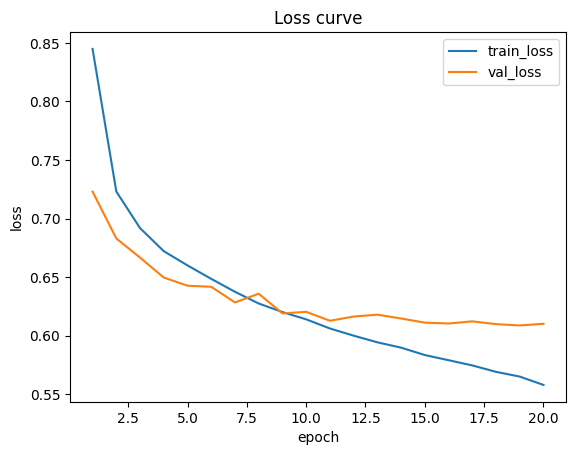

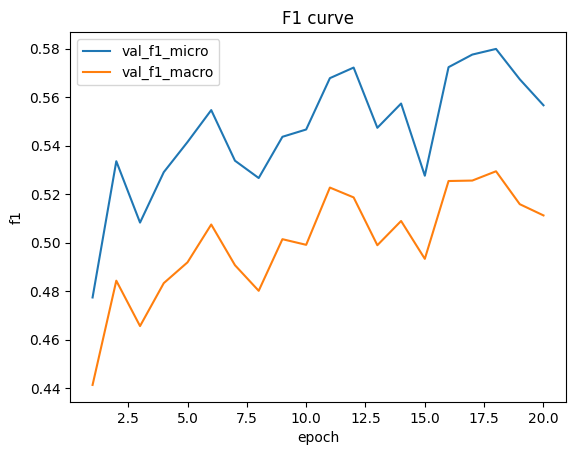

In [27]:
encoder = Thai2VecEncoder()

pipe = Thai2VecMLPPipeline(
    preprocessing=preprocessing,     
    encoder=encoder,                
    label_names=label_cols,
    batch_size=64,
    epochs=20,
    lr=1e-3,
    threshold=0.5,
    hidden_dim=256,
    dropout=0.2
)


history = pipe.fit(
    X_train_texts=X_train, y_train=Y_train,
    X_val_texts=X_valid,   y_val=Y_valid,
    showdetail=True
)
plot_history(history)

In [28]:
# Test evaluation
y_true, y_pred = pipe.evaluate(X_test, Y_test, print_report=True)

f1_micro=0.5822 | f1_macro=0.5305
                   precision    recall  f1-score   support

         politics       0.80      0.74      0.77      3842
     human_rights       0.50      0.76      0.60      1511
  quality_of_life       0.47      0.80      0.59      1127
    international       0.55      0.89      0.68       834
           social       0.25      0.74      0.38       789
      environment       0.44      0.86      0.58       772
        economics       0.32      0.87      0.47       519
          culture       0.32      0.83      0.46       398
            labor       0.48      0.91      0.63       350
national_security       0.23      0.81      0.36       338
              ict       0.34      0.91      0.49       292
        education       0.23      0.81      0.36       255

        micro avg       0.46      0.79      0.58     11027
        macro avg       0.41      0.83      0.53     11027
     weighted avg       0.55      0.79      0.62     11027
      samples avg   

In [33]:
test_texts = [
    "ศาลสั่งเพิกถอนคำสั่งและคุ้มครองสิทธิเสรีภาพผู้ชุมนุม",
    "เศรษฐกิจชะลอจากดอกเบี้ยสูงและราคาพลังงาน",
    "กระทรวงศึกษาฯปรับหลักสูตรใหม่และเพิ่มงบโรงเรียน"
]

pred_matrix, pred_labels, proba = pipe.predict(test_texts)

for t, labs in zip(test_texts, pred_labels):
    print("\nTEXT:", t)
    print("PRED:", labs)


TEXT: ศาลสั่งเพิกถอนคำสั่งและคุ้มครองสิทธิเสรีภาพผู้ชุมนุม
PRED: ['politics', 'human_rights']

TEXT: เศรษฐกิจชะลอจากดอกเบี้ยสูงและราคาพลังงาน
PRED: ['environment', 'economics']

TEXT: กระทรวงศึกษาฯปรับหลักสูตรใหม่และเพิ่มงบโรงเรียน
PRED: ['environment', 'education']


old sol

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score


# -------------------------
# 1) Dataset wrapper
# -------------------------
class NumpyDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        """
        X: (n_docs, input_dim)  float
        Y: (n_docs, n_labels)   0/1 float
        """
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# -------------------------
# 2) MLP Model
# -------------------------
class MLPClassifier(nn.Module):
    def __init__(self, input_dim: int, n_labels: int, hidden_dim: int = 256, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, n_labels)
        )

    def forward(self, x):
        return self.net(x)


# -------------------------
# 3) Train / Eval loops
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad() # off backpropagation
def eval_one_epoch(model, loader, criterion, device, threshold=0.5):
    model.eval() # ปิด Dropout (ไม่สุ่ม) and make stable outcome
    total_loss = 0.0
    all_preds = []
    all_true = []

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)
        total_loss += loss.item() * Xb.size(0)

        preds = torch.sigmoid(logits) # 12 col [2.3, -0.1, ...]
        pred = (preds >= threshold).int()  # 0/1 per label
        all_preds.append(pred.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    all_pred = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)
    f1_micro = f1_score(all_true, all_pred, average='micro', zero_division=0)
    f1_macro = f1_score(all_true, all_pred, average='macro', zero_division=0)

    return total_loss / len(loader.dataset), f1_micro, f1_macro, all_true, all_pred


# -------------------------
# 4) Main training function (connect to your code)
# -------------------------
def train_mlp_from_thai2vec(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, label_names=None, batch_size=64, epochs=20, lr=1e-3, seed=42, threshold=0.5):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # typing check
    assert X_train.ndim == 2 # must be 2D (n_docs, input_dim)
    assert y_train.ndim == 2  # must be 2D (n_docs, n_labels)
    assert X_train.shape[0] == y_train.shape[0] # row equal?
    assert X_train.shape[1] == X_val.shape[1]
    assert y_train.shape[1] == y_val.shape[1]
    
    n_labels = y_train.shape[1]
    if label_names is None:
        label_names = [f"label_{i}" for i in range(n_labels)]
    else:
        assert len(label_names) == n_labels

    train_ds = NumpyDataset(X_train, y_train)
    val_ds = NumpyDataset(X_val, y_val)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = X_train.shape[1]    # should be 300
    model = MLPClassifier(input_dim=input_dim, n_labels=n_labels).to(device)
    pos = y_train.sum(axis=0)                 # จำนวน 1 ต่อ label
    neg = y_train.shape[0] - pos              # จำนวน 0 ต่อ label
    pos_weight = torch.tensor(neg / (pos + 1e-8), dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # การพลาด label ที่หายาก ต้องโดนลงโทษหนักกว่าปกติ
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, f1_micro, f1_macro, y_true, y_pred = eval_one_epoch(model, val_loader, criterion, device, threshold) # evaluate with validationset 1 time 

        if f1_micro > best_val_acc:
            best_val_acc = f1_micro
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} # best_state[k] = v.cpu().clone()

        print(f"Training epochs: {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | f1_micro={f1_micro:.4f} | f1_macro={f1_macro:.4f}")

    # load best
    assert best_state is not None
    model.load_state_dict(best_state)

    # final report
    _, _, _, y_true, y_pred = eval_one_epoch(model, val_loader, criterion, device)
    print("\nThai2Vec feed by MLP classification report (per label):")
    print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

    return model, label_names, device


@torch.no_grad()
def predict_multilabel(texts, preprocessing, encoder, model, label_names, device, threshold=0.5):
    """
    texts: list[str]
    return:
      - pred_matrix: (n, n_labels) 0/1
      - pred_labels: list[list[str]] รายชื่อ label ที่ติด
      - proba: (n, n_labels) probability ต่อ label
    """
    tovec_list, _ = preprocessing(texts)
    X_vec = encoder.transform(tovec_list)  # (n, 300)

    X_t = torch.from_numpy(X_vec).float().to(device)
    model.eval()
    logits = model(X_t)
    proba = torch.sigmoid(logits).cpu().numpy()
    pred_matrix = (proba >= threshold).astype(int)

    pred_labels = []
    for row in pred_matrix:
        pred_labels.append([label_names[i] for i, v in enumerate(row) if v == 1])

    return pred_matrix, pred_labels, proba

In [15]:
tovec_list, _ = preprocessing(X_train)
encoder = Thai2VecEncoder()
X_train_vec = encoder.transform(tovec_list)   # (n_docs, 300)

tovec_list2, _2 = preprocessing(X_valid)

X_val_vec = encoder.transform(tovec_list2)   # (n_docs, 300)

In [16]:

label_cols = [ "politics","human_rights","quality_of_life","international","social","environment","economics","culture","labor","national_security","ict","education"]
model, label_names, device = train_mlp_from_thai2vec(X_train_vec, Y_train, X_val_vec, Y_valid, label_names=label_cols)

Training epochs: 01 | train_loss=1.1875 | val_loss=1.1602 | f1_micro=0.2383 | f1_macro=0.2546
Training epochs: 02 | train_loss=1.0900 | val_loss=0.9935 | f1_micro=0.3762 | f1_macro=0.3469
Training epochs: 03 | train_loss=0.9471 | val_loss=0.8836 | f1_micro=0.4357 | f1_macro=0.3856
Training epochs: 04 | train_loss=0.8695 | val_loss=0.8467 | f1_micro=0.4525 | f1_macro=0.4108
Training epochs: 05 | train_loss=0.8307 | val_loss=0.8148 | f1_micro=0.4569 | f1_macro=0.4060
Training epochs: 06 | train_loss=0.7994 | val_loss=0.8045 | f1_micro=0.4918 | f1_macro=0.4378
Training epochs: 07 | train_loss=0.7781 | val_loss=0.7933 | f1_micro=0.4841 | f1_macro=0.4284
Training epochs: 08 | train_loss=0.7587 | val_loss=0.7894 | f1_micro=0.4729 | f1_macro=0.4309
Training epochs: 09 | train_loss=0.7555 | val_loss=0.7745 | f1_micro=0.4505 | f1_macro=0.4104
Training epochs: 10 | train_loss=0.7340 | val_loss=0.7682 | f1_micro=0.4639 | f1_macro=0.4214
Training epochs: 11 | train_loss=0.7189 | val_loss=0.7646 | 

In [17]:
test_texts = [
    "ศาลสั่งเพิกถอนคำสั่งและคุ้มครองสิทธิเสรีภาพผู้ชุมนุม",
    "เศรษฐกิจชะลอจากดอกเบี้ยสูงและราคาพลังงาน",
    "กระทรวงศึกษาฯปรับหลักสูตรใหม่และเพิ่มงบโรงเรียน"
]

pred_matrix, pred_labels, proba = predict_multilabel(
    test_texts, preprocessing, encoder, model, label_names, device, threshold=0.5
)

for t, labs in zip(test_texts, pred_labels):
    print("\nTEXT:", t)
    print("PRED:", labs)



TEXT: ศาลสั่งเพิกถอนคำสั่งและคุ้มครองสิทธิเสรีภาพผู้ชุมนุม
PRED: ['politics', 'human_rights']

TEXT: เศรษฐกิจชะลอจากดอกเบี้ยสูงและราคาพลังงาน
PRED: ['quality_of_life', 'social', 'environment', 'economics']

TEXT: กระทรวงศึกษาฯปรับหลักสูตรใหม่และเพิ่มงบโรงเรียน
PRED: ['quality_of_life', 'international', 'social', 'culture', 'education']
